### Wakefield simulation of accelerator cavity with `wakis`

* EM Simulation of a lossy cylindrical accelerator cavity 
* Calculation of the longitudinal wake potential and impedance
* Plotting in 3d, 2d, 1d of the results

| Geometry  | Wake potential  | Impedance  |
| --- | --- | --- | 
| 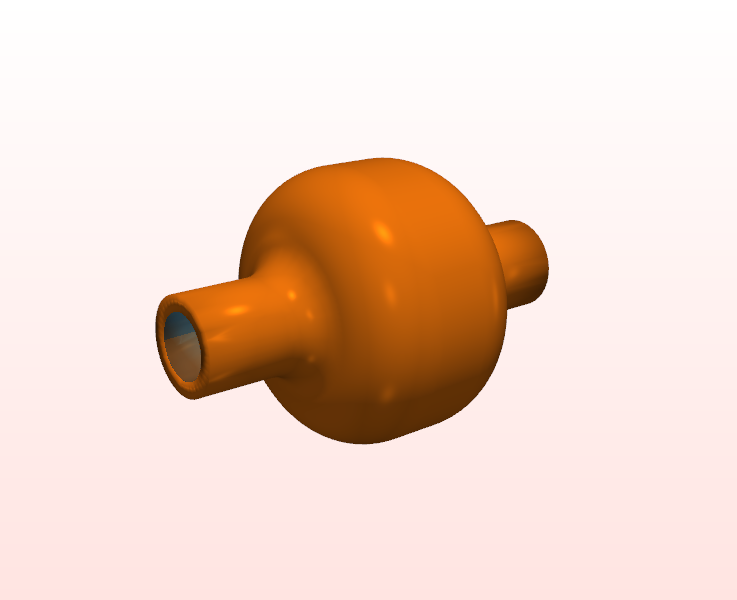 |  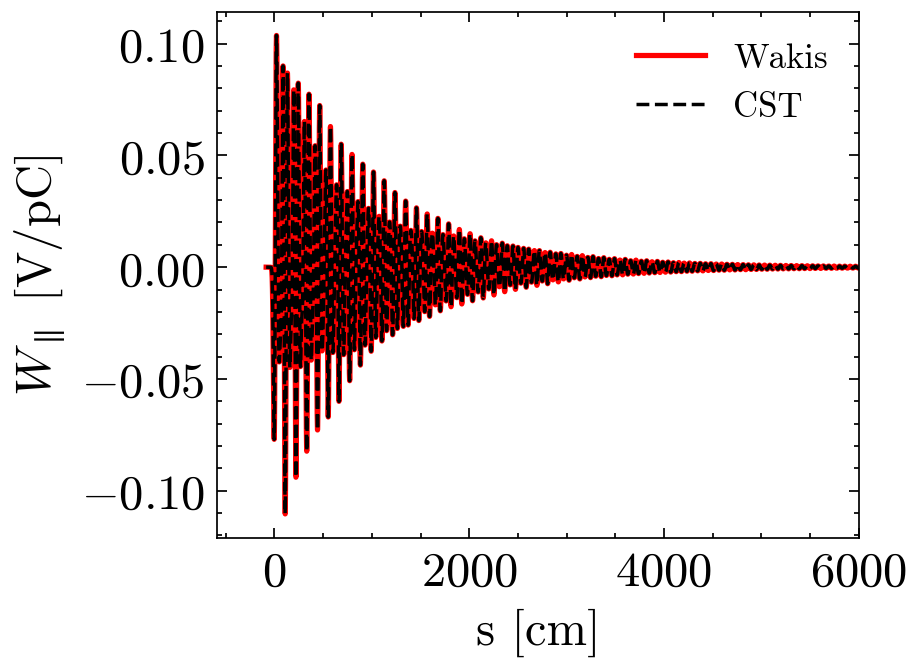  |  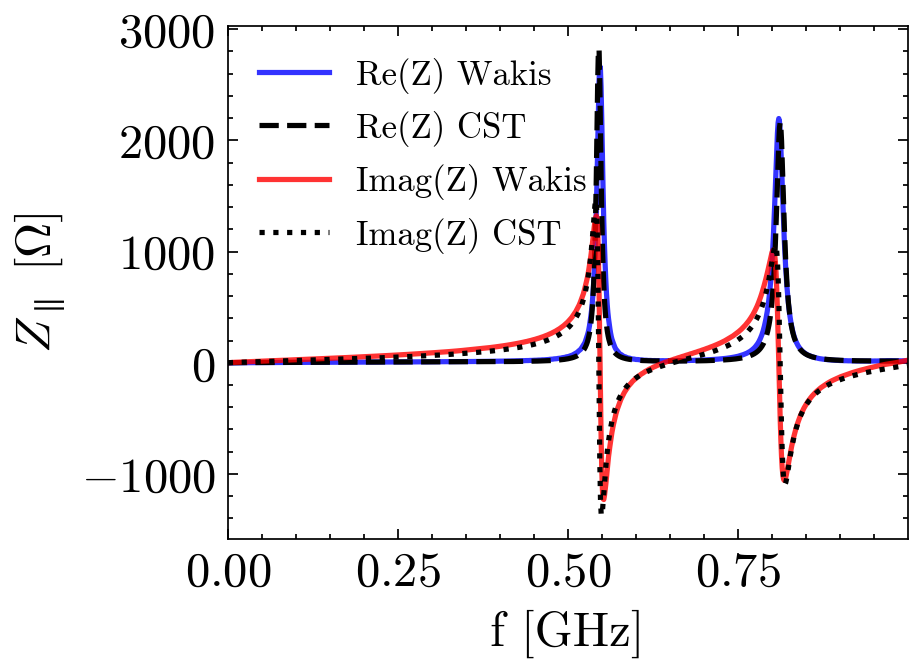   |

In [1]:
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt

from wakis import SolverFIT3D
from wakis import GridFIT3D 
from wakis import WakeSolver

%matplotlib ipympl

### Domain setup and grid generation

In [ ]:
# Read geometry
stl_cavity = 'data/002_vacuum_cavity.stl' 
stl_shell = 'data/002_lossymetal_shell.stl'

pl = pv.Plotter()
pl.add_mesh(pv.read(stl_shell),color='tab:orange', specular=0.5, smooth_shading=True)
pl.add_mesh(pv.read(stl_cavity),color='tab:blue', opacity=0.5, specular=0.5, smooth_shading=True)
pl.set_background('mistyrose', top='white')
pl.show()

In [ ]:
# ---------- Domain setup ---------
# Number of mesh cells
Nx = 80
Ny = 80
Nz = 141
#dt = 2.187760221e-12 # like CST

stl_solids = {'cavity': stl_cavity, 'shell': stl_shell}
stl_materials = {'cavity': 'vacuum', 'shell': [30, 1.0, 30]}

# Domain bounds
surf = pv.read(stl_shell) + pv.read(stl_cavity)
xmin, xmax, ymin, ymax, zmin, zmax = surf.bounds
Lx, Ly, Lz = (xmax-xmin), (ymax-ymin), (zmax-zmin)

# set grid and geometry
grid = GridFIT3D(xmin, xmax, ymin, ymax, zmin, zmax, Nx, Ny, Nz, 
                stl_solids=stl_solids, 
                stl_materials=stl_materials,
                stl_scale=1.0)

grid.inspect(stl_colors=['blue', 'tab:orange'])

### Boundary conditions and EM solver

In [ ]:
# boundary conditions
bc_low=['pec', 'pec', 'pec']
bc_high=['pec', 'pec', 'pec']

solver = SolverFIT3D(grid, 
                     bc_low=bc_low, bc_high=bc_high, 
                     use_stl=True, bg='pec')

### Wakefield settings

In [ ]:
# ------------ Beam source ----------------
# Beam parameters
sigmaz = 10e-2      #[m] -> 2 GHz
q = 1e-9            #[C]
beta = 1.0          # beam beta 
xs = 0.             # x source position [m]
ys = 0.             # y source position [m]
xt = 0.             # x test position [m]
yt = 0.             # y test position [m]
# [DEFAULT] tinj = 8.53*sigmaz/c_light  # injection time offset [s] 


# ----------- Solver  setup  ----------
# Wakefield post-processor
wakelength = 10. #[m]
add_space = 10   # no. cells

wake = WakeSolver(q=q, sigmaz=sigmaz, beta=beta,
                xsource=xs, ysource=ys, xtest=xt, ytest=yt,
                add_space=add_space,
                results_folder='results/',
                Ez_file='results/001_Ez.h5',)

### Simulation run and plotting of wake results

In [ ]:
solver.wakesolve(wakelength=wakelength, 
                 wake=wake, 
                 add_space=add_space,
                 plot=False)

In [ ]:
# For scientific paper like plots 
import scienceplots
plt.style.use(['science','ieee'])

# Compare to benchmark data, if available
compare_to_CST = False

fig, ax = plt.subplots(1,2, figsize=[12,4], dpi=150)
ax[0].plot(wake.s[0]*1e2, wake.WP[1], c='r', lw=1.5, label='Wakis')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='r')
ax[0].legend()

ax[1].plot(wake.f*1e-9, np.abs(wake.Z), c='b', lw=1.5, label='Wakis')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='b')
ax[1].legend()

if compare_to_CST:
    # CST wake
    cstWP = wake.read_txt('cst/WP.txt')
    cstZ = wake.read_txt('cst/Z.txt')
    ax[0].plot(cstWP[0], cstWP[1], c='k', ls='--', lw=1.5, label='CST')
    ax[1].plot(cstZ[0], cstZ[1], c='k', ls='--', lw=1.5, label='CST')

fig.suptitle('Benchmark with CST Wakefield Solver')
fig.tight_layout()
fig.savefig('results/benchmark.png')

plt.show()

---------------
### Running particular cases

In [73]:
# Plot settings
import os
if not os.path.exists('img/'): os.mkdir('img/')
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('name', plt.cm.jet(np.linspace(0.1, 0.9))) # CST's colormap

plotkw2D = {'title':'img/Ez', 
            'add_patch':['cavity'], 'patch_alpha':1.0,
            'patch_reverse' : True, 
            'vmin':-1e3, 'vmax':1e3,
            'cmap': cmap,
            'plane': [int(Nx/2), slice(0, Ny), slice(add_space, -add_space)]}

plotkw3D = {'title':'img/Ez3d', 
            'add_stl':'shell',
            'field_opacity':0.5,}


#### Running and 3d plotting $E_{Abs}$ on-the-fly

In [ ]:
from wakis.sources import Beam
from tqdm import tqdm

beam = Beam(q=q, sigmaz=sigmaz, beta=beta,
            xsource=xs, ysource=ys)

Nt = 3000           
for n in tqdm(range(Nt)):

    beam.update(solver, n*solver.dt)

    if n%500 == 0 and n>3000:
        solver.plot3DonSTL('E', component='Abs', cmap=cmap, clim=[0, 500],
            stl_with_field='cavity', field_opacity=1.0,
            stl_transparent='shell', stl_opacity=0.1, stl_colors='white',
            clip_plane=True, clip_normal='-y', clip_origin=[0,0,0],
            off_screen=True, zoom=1.2, n=n, title='img/Ez')
        
    solver.one_step()

#### Running with `emsolve` to calculate only EM fields

In [ ]:
from wakis.sources import Beam
beam = Beam(q=q, sigmaz=sigmaz, beta=beta,
            xsource=xs, ysource=ys)

solver.emsolve(Nt=8000, source=beam,
                plot=True, plot_every=100, 
                **plotkw2D)

#### Load wake results

In [ ]:
wake.load_results(folder='results/')